In [2]:
path=r'data/output.csv'

CNN-lstm after reducing overfitting 

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder,MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

def create_cnn_lstm_model(input_shape, num_classes):
    model = Sequential([
        # First Conv1D block
        Conv1D(filters=32, kernel_size=3, activation='relu', 
               kernel_regularizer=l2(0.001), input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        
        # Second Conv1D block
        Conv1D(filters=64, kernel_size=3, activation='relu',
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        
        # Optimized single LSTM layer (no recurrent dropout for speed)
        LSTM(64, dropout=0.3),
        
        # Dense layer
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),
        
        # Output layer with float32 (for mixed precision compatibility)
        Dense(num_classes, activation='softmax', dtype='float32')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [4]:
def preprocess_data(X, y, test_size=0.2, val_size=0.2):
    """Preprocess data: scale features and split into train, test, validation sets"""
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, 
                                                        stratify=y, random_state=42)
    
    # Split train set into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, 
                                                      stratify=y_train, random_state=42)
    
    # Scale the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    # Reshape for CNN (samples, timesteps, features)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

def data_augmentation(X, y):
    """Apply data augmentation to increase dataset size and variety"""
    X_augmented = [X]
    y_augmented = [y]
    
    # Adding random noise
    noise_factor = 0.05
    X_noise = X + np.random.normal(0, noise_factor, X.shape)
    X_augmented.append(X_noise)
    y_augmented.append(y)
    
    # Magnitude scaling
    scale_factor = np.random.uniform(0.8, 1.2)
    X_scaled = X * scale_factor
    X_augmented.append(X_scaled)
    y_augmented.append(y)
    
    # Time shifting
    shift = np.random.randint(1, 3)
    X_shifted = np.roll(X, shift, axis=1)
    X_augmented.append(X_shifted)
    y_augmented.append(y)
    
    # Combine augmented data
    X_aug = np.vstack(X_augmented)
    y_aug = np.hstack(y_augmented)
    
    # Shuffle the augmented data
    indices = np.arange(X_aug.shape[0])
    np.random.shuffle(indices)
    X_aug = X_aug[indices]
    y_aug = y_aug[indices]
    
    return X_aug, y_aug


In [5]:
from tensorflow.keras import backend as K

def focal_loss(gamma=2., alpha=0.25):
    """
    Focal loss for dealing with class imbalance
    """
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1 + K.epsilon())) - \
               K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
    return focal_loss_fixed


In [6]:
def train_model(X_train, y_train, X_val, y_val, input_shape, num_classes, 
                batch_size=64, epochs=50, use_focal_loss=False):
    """Train the CNN-LSTM model with all overfitting prevention techniques"""
    
    # Apply data augmentation to increase training data diversity
    X_train_aug, y_train_aug = data_augmentation(X_train, y_train)
    
    # Calculate class weights for imbalanced data
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(enumerate(class_weights))
    
    # Create model
    model = create_cnn_lstm_model(input_shape, num_classes)
    
    # Use focal loss for imbalanced data if specified
    if use_focal_loss:
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss=focal_loss(),
            metrics=['accuracy']
        )
    
    # Print model summary
    model.summary()
    
    # Define callbacks for early stopping and learning rate reduction
    callbacks = [
        # Early stopping to prevent overfitting
        EarlyStopping(
            monitor='val_loss', 
            patience=10, 
            restore_best_weights=True, 
            verbose=1
        ),
        
        # Learning rate scheduler - reduce learning rate when stuck
        ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.5, 
            patience=5, 
            min_lr=1e-6, 
            verbose=1
        ),
        
        # Model checkpoint to save best model
        ModelCheckpoint(
            'best_model.h5', 
            monitor='val_loss', 
            save_best_only=True, 
            verbose=1
        )
    ]
    
    # Train the model
    history = model.fit(
        X_train_aug, y_train_aug,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        class_weight=class_weight_dict,
        verbose=1
    )
    
    return model, history


In [7]:
def evaluate_model(model, X_test, y_test):
    """Evaluate model performance and visualize results"""
    
    # Predict on test data
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    # Print classification report
    print('\nClassification Report:')
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Calculate test accuracy
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {test_accuracy:.4f}")
    
def plot_training_history(history):
    """Plot training and validation metrics"""
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


In [8]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [9]:
#Load dataset
df = pd.read_csv(path)
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [10]:
df.shape

(2300825, 79)

In [11]:
df.describe()

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,2.300825e+06,2.300825e+06,2.300825e+06,2.300825e+06,2.300825e+06,2.300825e+06,2.300825e+06,2.300825e+06,2.300825e+06,2.300825e+06,...,2.300825e+06,2.300825e+06,2.300825e+06,2.300825e+06,2.300825e+06,2.300825e+06,2.300825e+06,2.300825e+06,2.300825e+06,2.300825e+06
mean,7.478905e+03,1.579823e+07,9.124129e+00,1.013505e+01,5.531908e+02,1.576287e+04,2.114469e+02,1.835353e+01,5.991961e+01,7.154907e+01,...,4.958900e+00,-2.540647e+03,8.457227e+04,4.065386e+04,1.549771e+05,6.163359e+04,9.433560e+06,5.732621e+05,9.864630e+06,8.990073e+06
std,1.743643e+04,3.460566e+07,7.127588e+02,9.522747e+02,1.067420e+04,2.156969e+06,7.657296e+02,6.461895e+01,2.015989e+02,3.038008e+02,...,5.755252e+02,1.173879e+06,6.618916e+05,3.925080e+05,1.025175e+06,5.935032e+05,2.532916e+07,4.995685e+06,2.611131e+07,2.506222e+07
min,0.000000e+00,-1.300000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,-5.368707e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.300000e+01,1.470000e+02,1.000000e+00,1.000000e+00,6.000000e+00,2.000000e+00,6.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,...,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.000000e+01,3.132200e+04,2.000000e+00,2.000000e+00,6.000000e+01,1.200000e+02,3.600000e+01,2.000000e+00,3.300000e+01,0.000000e+00,...,1.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.430000e+02,4.582168e+06,5.000000e+00,4.000000e+00,1.870000e+02,5.680000e+02,8.100000e+01,3.500000e+01,4.928571e+01,2.327660e+01,...,2.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,6.553300e+04,1.200000e+08,2.079640e+05,2.846020e+05,1.290000e+07,6.270000e+08,2.482000e+04,2.325000e+03,5.940857e+03,7.049469e+03,...,1.986360e+05,1.380000e+02,1.100000e+08,7.420000e+07,1.100000e+08,1.100000e+08,1.200000e+08,7.690000e+07,1.200000e+08,1.200000e+08


In [12]:
df.columns

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Co

In [13]:
df.isnull().sum()
df.isna().sum()

Destination Port               0
Flow Duration                  0
Total Fwd Packets              0
Total Backward Packets         0
Total Length of Fwd Packets    0
                              ..
Idle Mean                      0
Idle Std                       0
Idle Max                       0
Idle Min                       0
Label                          0
Length: 79, dtype: int64

In [14]:
df['Label'].value_counts()

Label
BENIGN                        1743179
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

In [15]:
# Define mapping dictionary
label_mapping = {
    'BENIGN': 'Benign Traffic',
    'DoS Hulk': 'DoS Attacks',
    'DoS GoldenEye': 'DoS Attacks',
    'DoS slowloris': 'DoS Attacks',
    'DoS Slowhttptest': 'DoS Attacks',
    'DDoS': 'DDoS Attacks',
    'PortScan': 'Port Scanning & Brute Force',
    'FTP-Patator': 'Port Scanning & Brute Force',
    'SSH-Patator': 'Port Scanning & Brute Force',
    'Web Attack – Brute Force': 'Web-Based Attacks',
    'Web Attack – XSS': 'Web-Based Attacks',
    'Web Attack – Sql Injection': 'Web-Based Attacks',
    'Bot': 'Other Exploits & Infiltrations',
    ' Infiltration': 'Other Exploits & Infiltrations',
    'Heartbleed': 'Other Exploits & Infiltrations'
}

# Apply mapping to create a new column with grouped labels
df['Label'] = df['Label'].map(label_mapping)
df['Label'].value_counts()


Label
Benign Traffic                    1743179
DoS Attacks                        252661
Port Scanning & Brute Force        172765
DDoS Attacks                       128027
Other Exploits & Infiltrations       1977
Name: count, dtype: int64

In [16]:
df.columns

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Co

In [17]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the grouped labels
df['Label'] = label_encoder.fit_transform(df['Label'])

In [18]:
df['Label'].value_counts()

Label
0    1743179
2     252661
4     172765
1     128027
5       2216
3       1977
Name: count, dtype: int64

In [19]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)  # Convert inf to NaN

df.fillna(df.median(), inplace=True)  # Replace NaN with max finite value


<Axes: title={'center': 'Count (target)'}, xlabel='Label'>

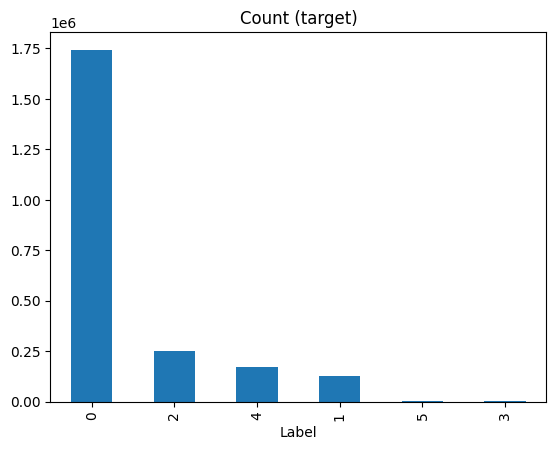

In [20]:
df['Label'].value_counts().plot(kind='bar', title='Count (target)')

In [21]:
# Normalize features
scaler = MinMaxScaler()

X = df.drop(columns=['Label']).values
X_scaled = scaler.fit_transform(X)
y = df['Label'].values
y_encoded = to_categorical(y)

Training set shape: (1472528, 78, 1)
Validation set shape: (368132, 78, 1)
Test set shape: (460165, 78, 1)
Number of classes: 6
Class distribution in training set: [1115634   81938  161703    1265  110570    1418]


14381/14381 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.87      0.92    348636
           1       0.75      1.00      0.85     25605
           2       0.91      0.86      0.89     50532
           3       0.01      0.29      0.02       396
           4       0.82      0.94      0.87     34553
           5       0.04      0.98      0.07       443

    accuracy                           0.88    460165
   macro avg       0.58      0.82      0.60    460165
weighted avg       0.94      0.88      0.91    460165



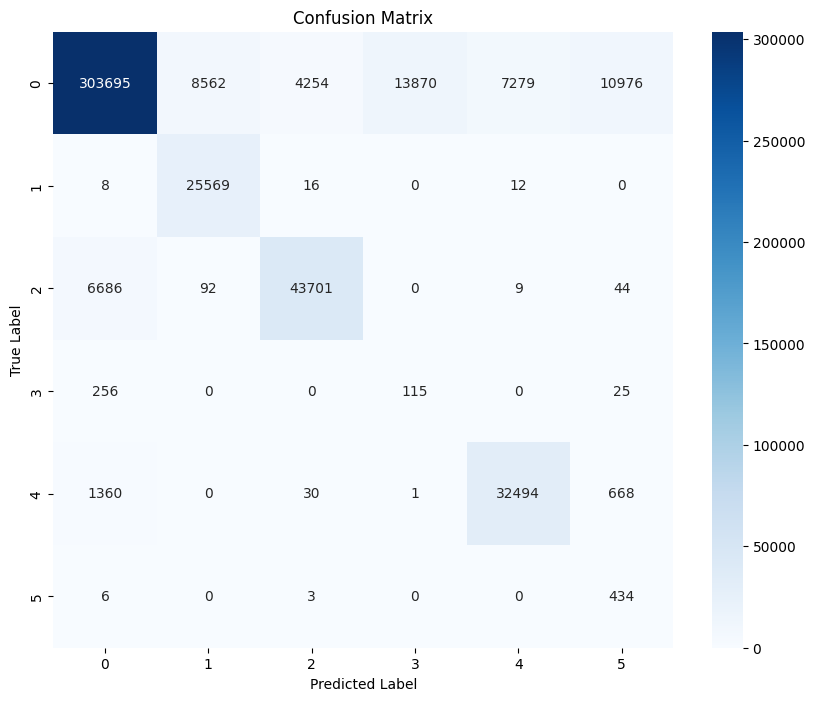

14381/14381 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - accuracy: 0.8820 - loss: 0.3986
Test accuracy: 0.8823


In [22]:
def main():
   
    # Preprocess data
    X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(X_scaled, y)
    
    # Get input shape for the model
    input_shape = (X_train.shape[1], X_train.shape[2])
    num_classes = len(np.unique(y))
    
    print(f"Training set shape: {X_train.shape}")
    print(f"Validation set shape: {X_val.shape}")
    print(f"Test set shape: {X_test.shape}")
    print(f"Number of classes: {num_classes}")
    
    # Check for class imbalance
    class_counts = np.bincount(y_train)
    print("Class distribution in training set:", class_counts)
    
    model = tf.keras.models.load_model('C:/Users/ASUS/Desktop/PBL/models/best_model.h5')
    # Evaluate and visualize results
    evaluate_model(model, X_test, y_test)
    

if __name__ == "__main__":
    main()
